In [1]:
from EEGModels import EEGNet
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import os
import scipy
import numpy as np
from sklearn.metrics import balanced_accuracy_score
import tensorflow as tf


In [3]:
%run "../functions/get_data.ipynb"
%run "../functions/trimmer.ipynb"
%run "../functions/training.ipynb"

In [ ]:
folder_path = '../data/initial_data/walk_inst_raw/'
file_list = get_file_list(folder_path)

print(file_list)

In [5]:
X, Y = get_data(file_list)

In [6]:
kernels, chans, samples = 1, 14, 500

In [5]:
index_1 = 2
index_2 = 8

X_train = [X[i] for i in range(len(X)) if i != index_1 and i != index_2]
Y_train = [Y[i] for i in range(len(Y)) if i != index_1 and i != index_2]

# build test set from the files with index_1 and index_2
X_test = [X[i] for i in range(len(X)) if i == index_1 or i == index_2]
Y_test = [Y[i] for i in range(len(Y)) if i == index_1 or i == index_2]

X_train = np.concatenate(X_train)
Y_train = np.concatenate(Y_train)
X_test = np.concatenate(X_test)
Y_test = np.concatenate(Y_test)

# convert data to NHWC (trials, channels, samples, kernels) format.
X_train = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_test = X_test.reshape(X_test.shape[0], chans, samples, kernels)


In [6]:
model = EEGNet(nb_classes=2, Chans=chans, Samples=samples, dropoutRate=0.5, kernLength=32, F1=8, D=2, F2=16, dropoutType='Dropout')

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()     

class_weights = {0:1, 1:1}

print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 500, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 14, 500, 8)        256       
                                                                 
 batch_normalization (BatchN  (None, 14, 500, 8)       32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 1, 500, 16)       224       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 500, 16)       64        
 hNormalization)                                                 
                                                             

In [7]:
fitted_model = model.fit(X_train, Y_train, batch_size = 32, epochs = 15, verbose = 2, 
                        class_weight=class_weights)

Epoch 1/15
24/24 - 6s - loss: 0.6882 - accuracy: 0.5591 - 6s/epoch - 244ms/step
Epoch 2/15
24/24 - 3s - loss: 0.6477 - accuracy: 0.6202 - 3s/epoch - 122ms/step
Epoch 3/15
24/24 - 3s - loss: 0.6360 - accuracy: 0.6600 - 3s/epoch - 124ms/step
Epoch 4/15
24/24 - 3s - loss: 0.6265 - accuracy: 0.6587 - 3s/epoch - 120ms/step
Epoch 5/15
24/24 - 3s - loss: 0.6004 - accuracy: 0.6919 - 3s/epoch - 124ms/step
Epoch 6/15
24/24 - 3s - loss: 0.5917 - accuracy: 0.6985 - 3s/epoch - 120ms/step
Epoch 7/15
24/24 - 3s - loss: 0.5844 - accuracy: 0.7211 - 3s/epoch - 123ms/step
Epoch 8/15
24/24 - 3s - loss: 0.5811 - accuracy: 0.7185 - 3s/epoch - 121ms/step
Epoch 9/15
24/24 - 3s - loss: 0.5696 - accuracy: 0.7477 - 3s/epoch - 121ms/step
Epoch 10/15
24/24 - 3s - loss: 0.5652 - accuracy: 0.7357 - 3s/epoch - 118ms/step
Epoch 11/15
24/24 - 3s - loss: 0.5668 - accuracy: 0.7264 - 3s/epoch - 120ms/step
Epoch 12/15
24/24 - 3s - loss: 0.5523 - accuracy: 0.7251 - 3s/epoch - 119ms/step
Epoch 13/15
24/24 - 3s - loss: 0.5505

In [38]:
import matplotlib.pyplot as plt
import cv2

1/1 [==============================] - 0s 261ms/step
Layer Name : input_1
Feature Maps Shape : (1, 14, 500, 1)


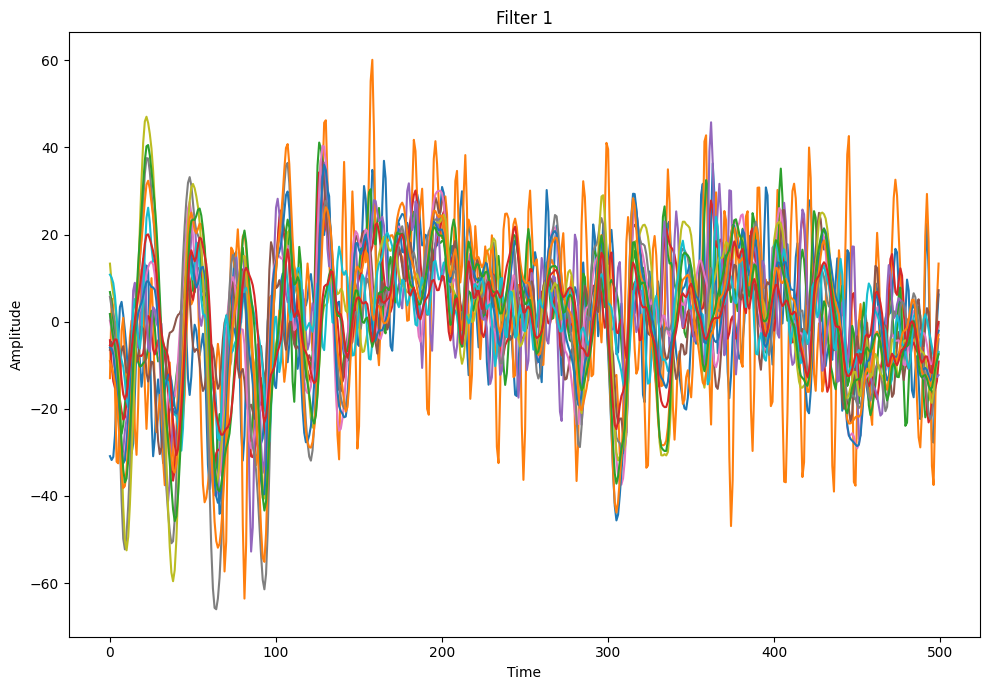

Layer Name : conv2d
Feature Maps Shape : (1, 14, 500, 8)


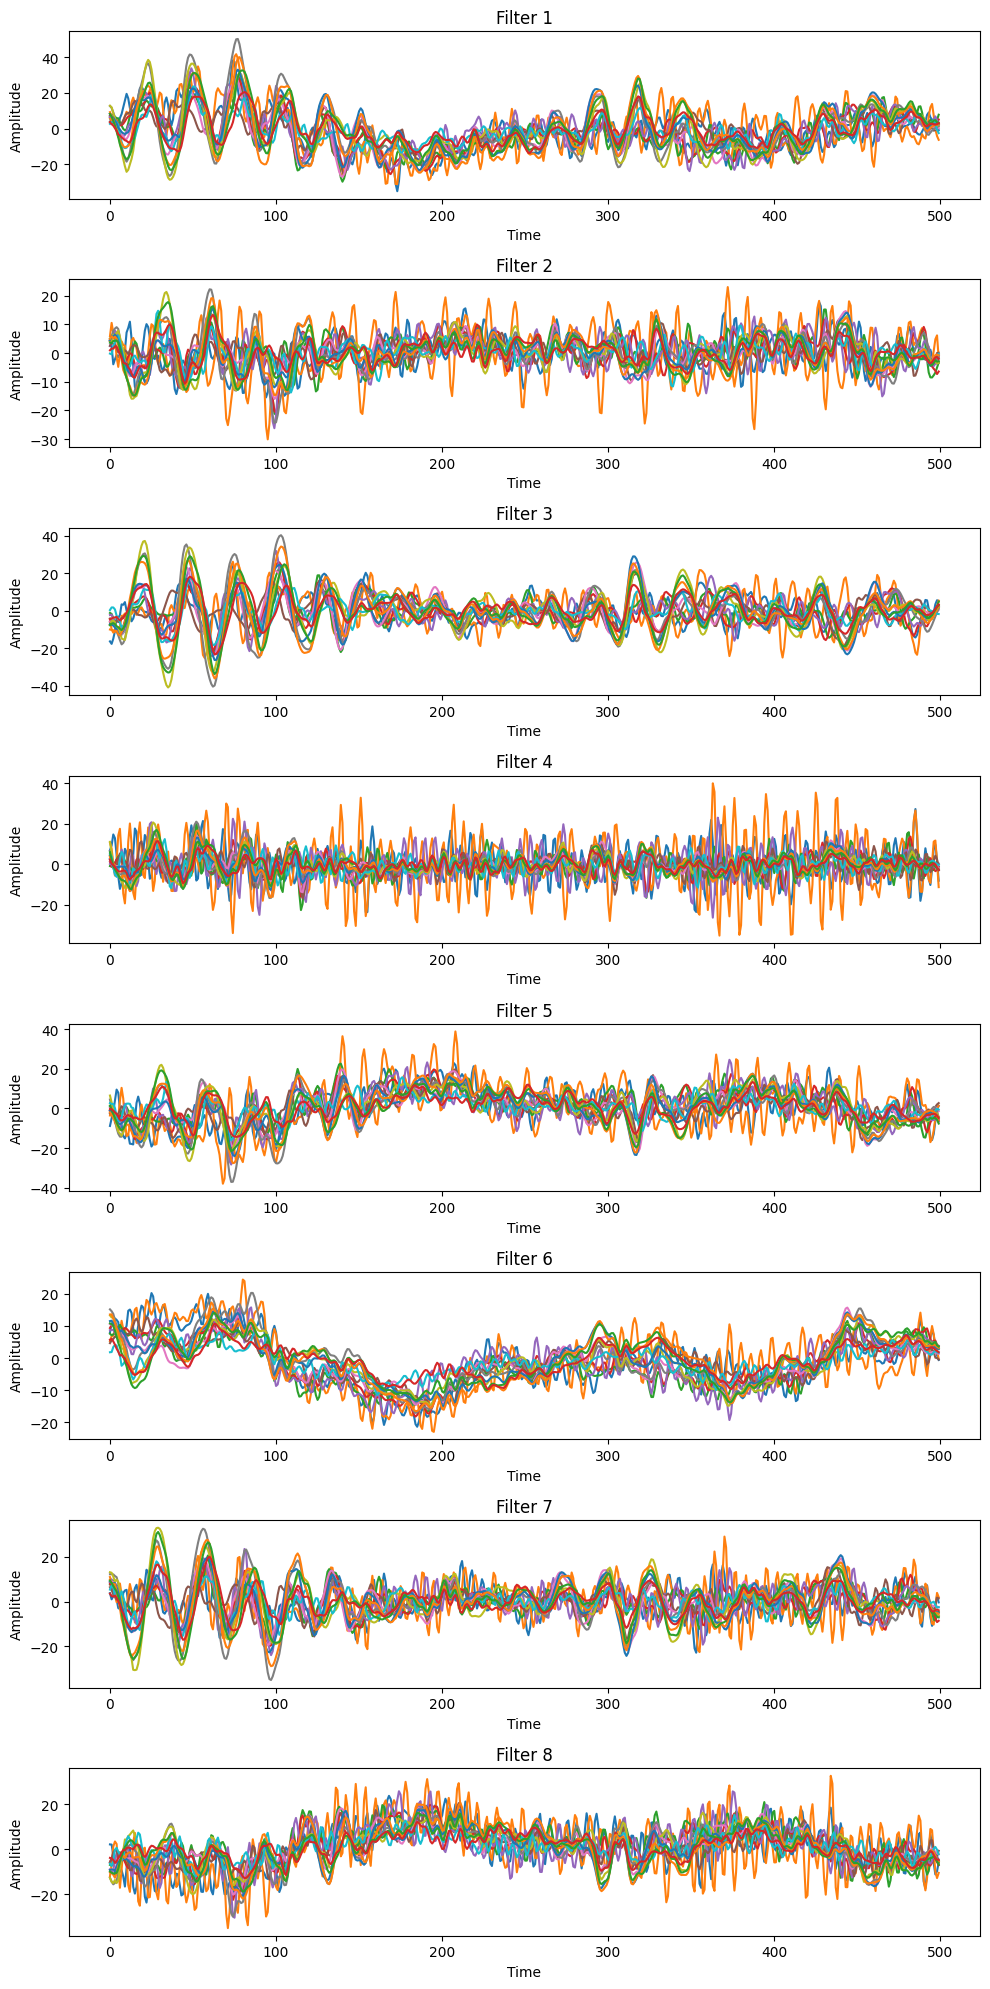

Layer Name : batch_normalization
Feature Maps Shape : (1, 14, 500, 8)


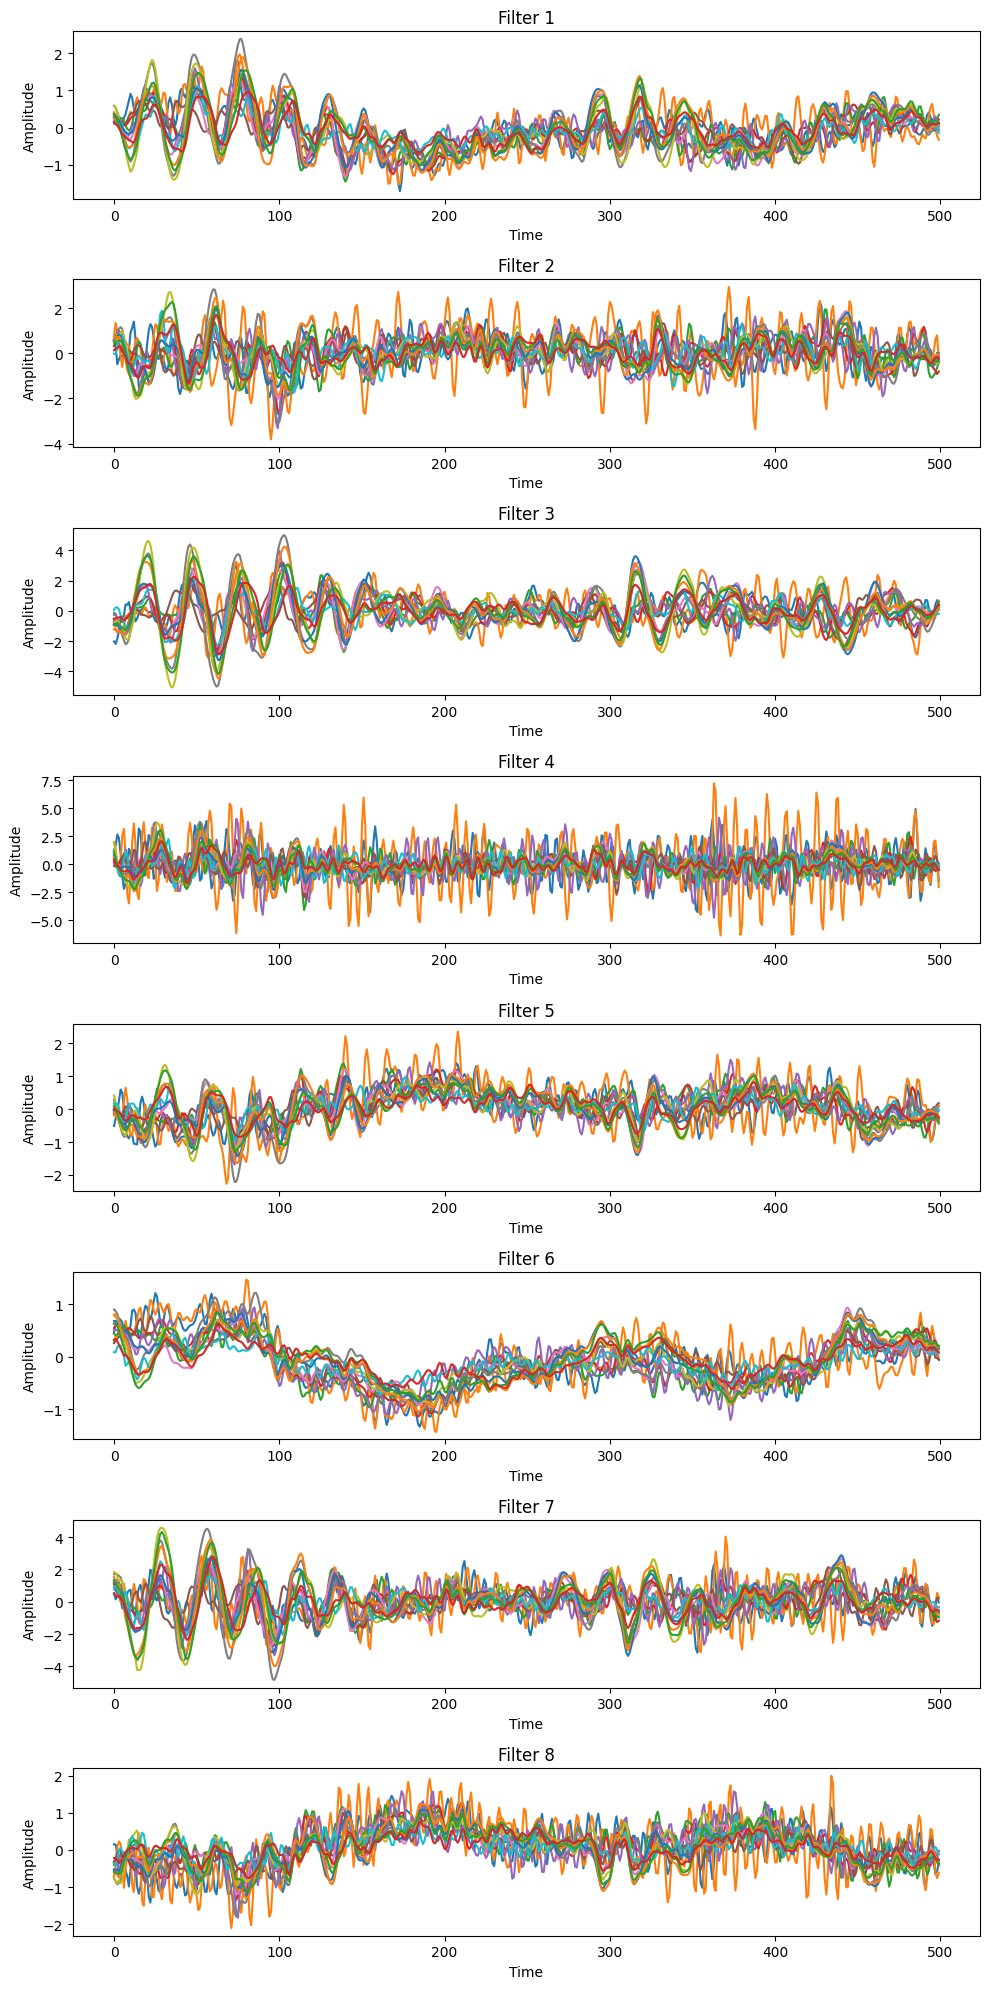

Layer Name : depthwise_conv2d
Feature Maps Shape : (1, 1, 500, 16)


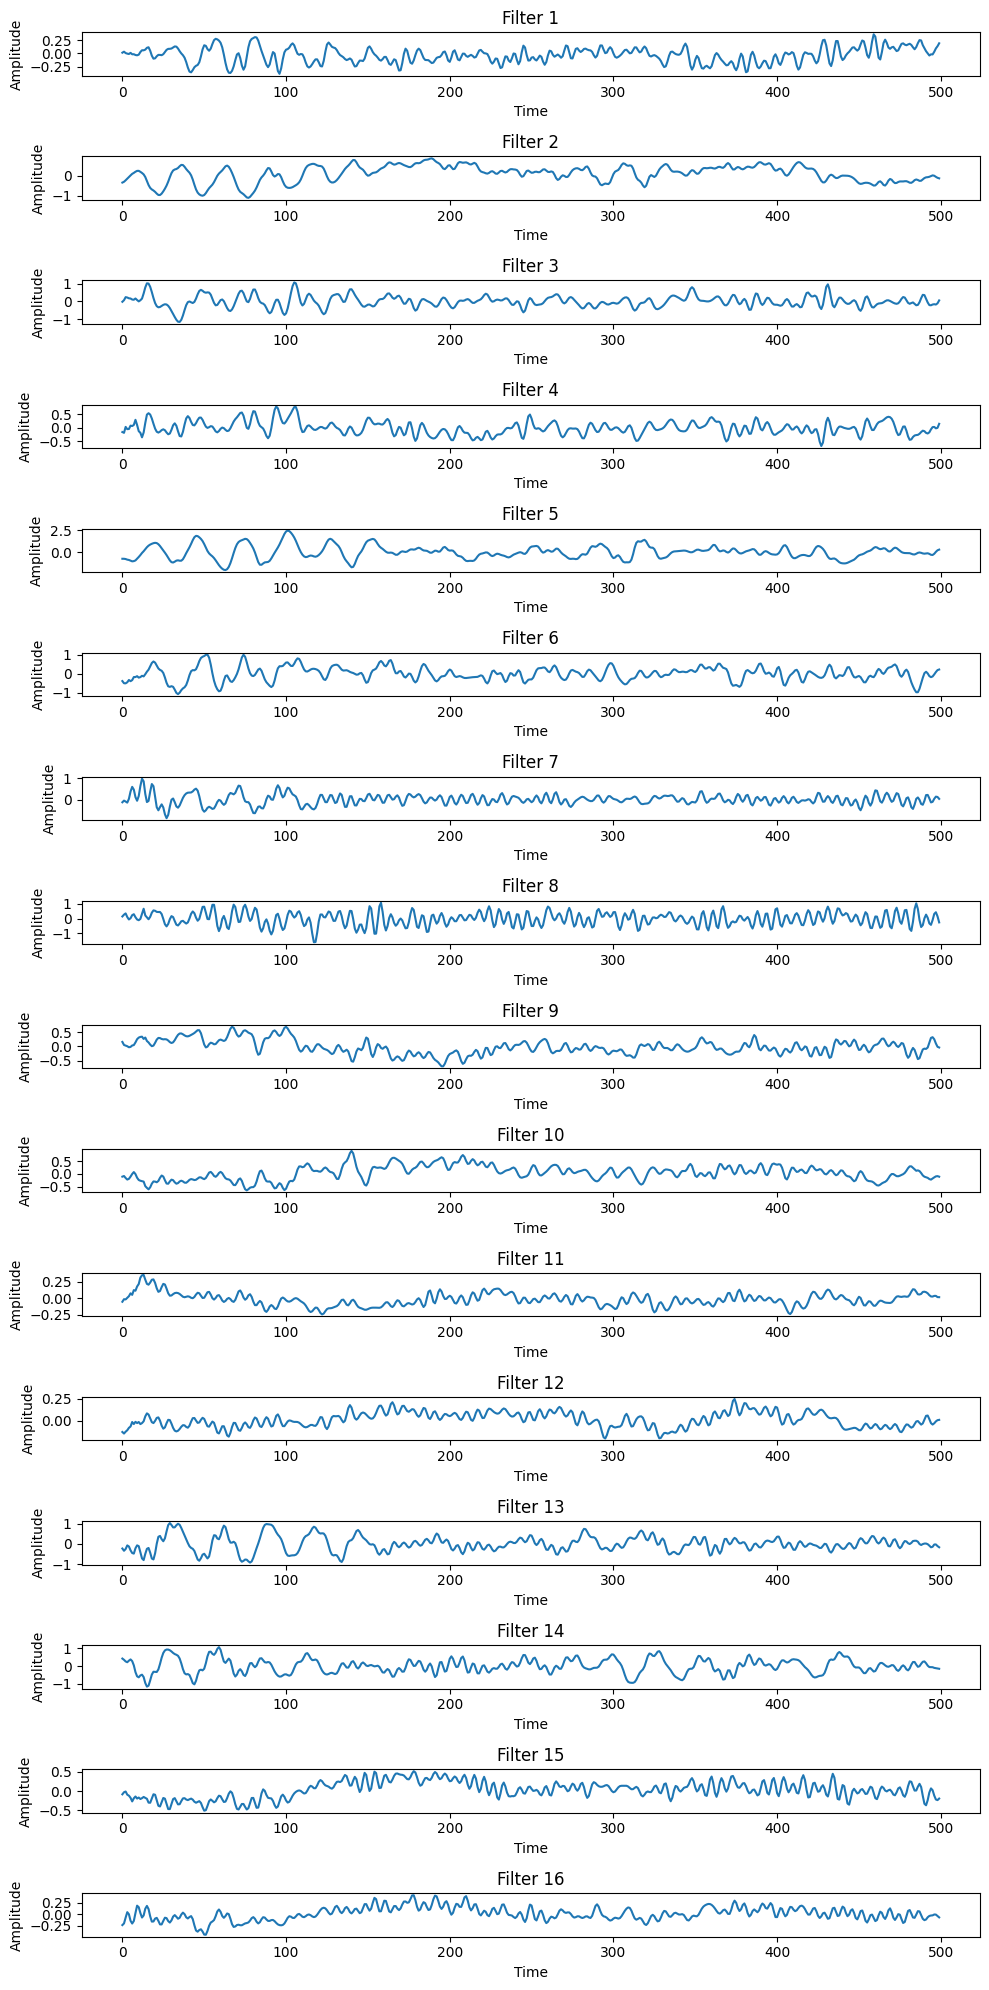

Layer Name : batch_normalization_1
Feature Maps Shape : (1, 1, 500, 16)


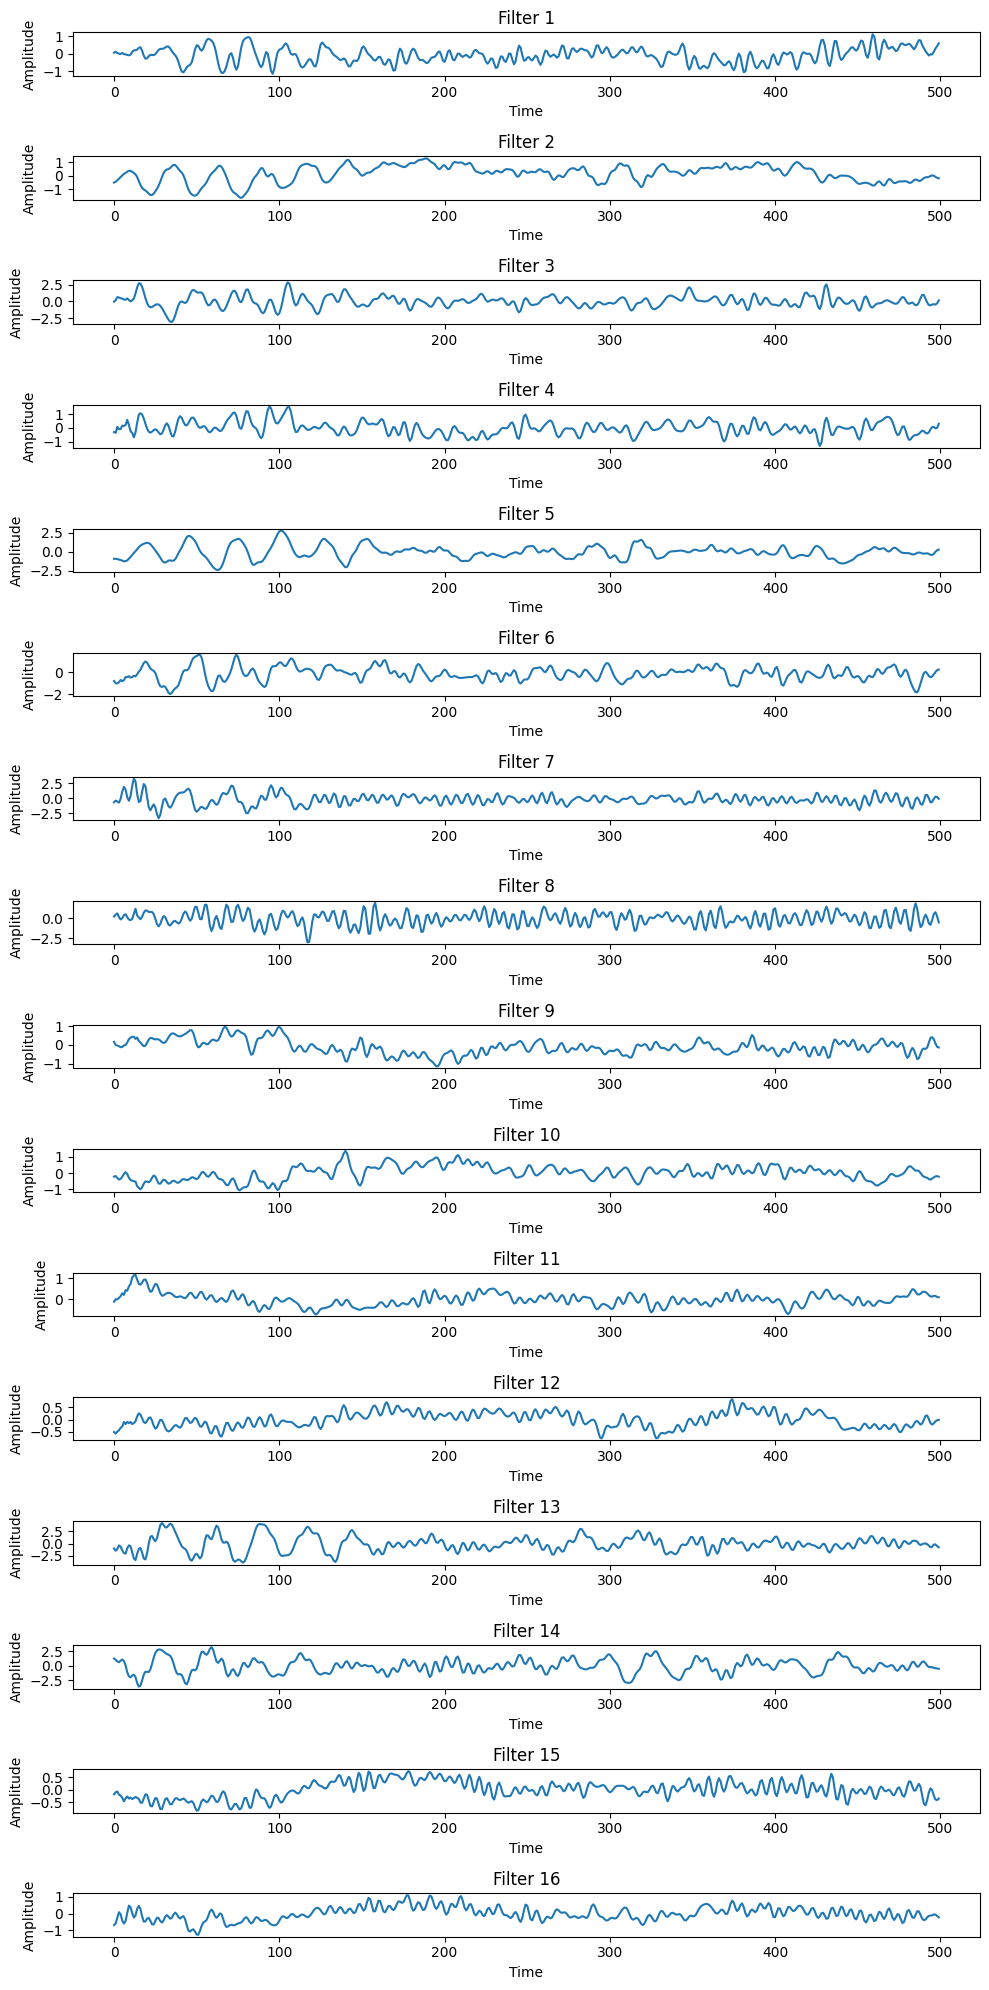

Layer Name : activation
Feature Maps Shape : (1, 1, 500, 16)


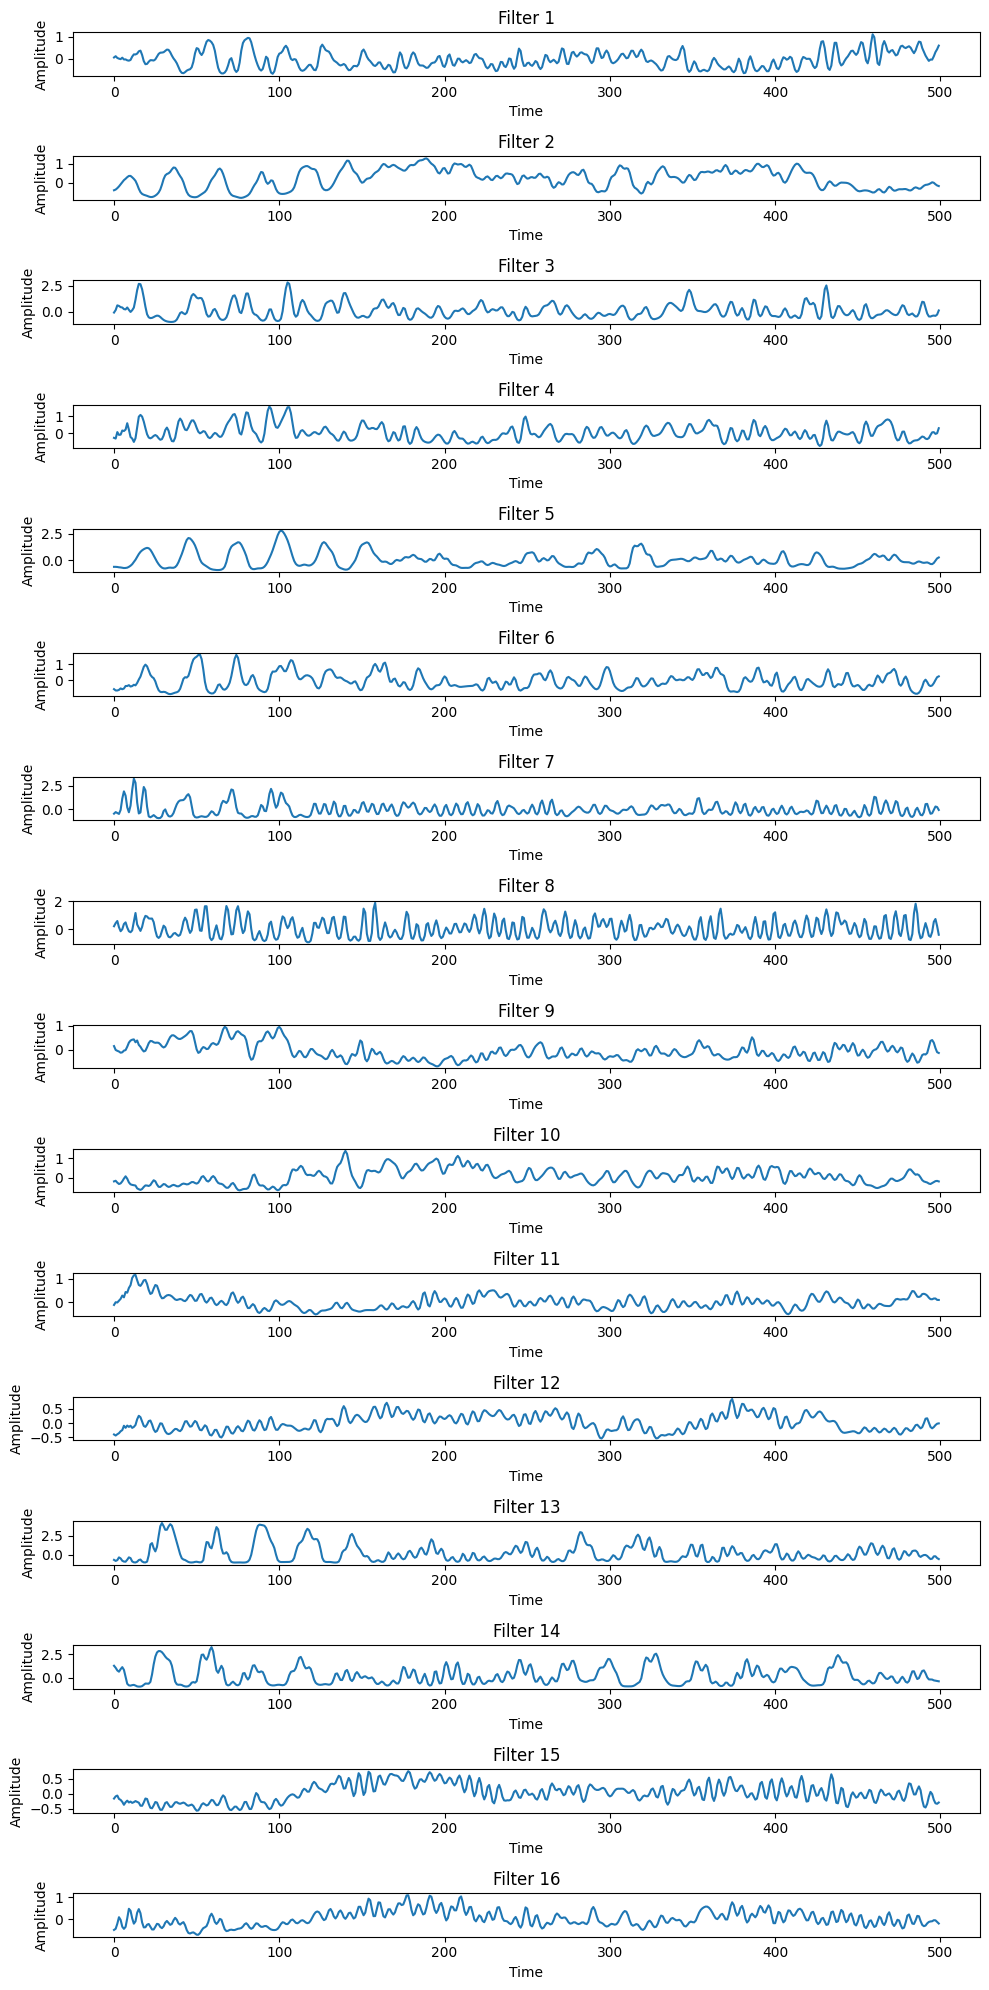

Layer Name : average_pooling2d
Feature Maps Shape : (1, 1, 125, 16)


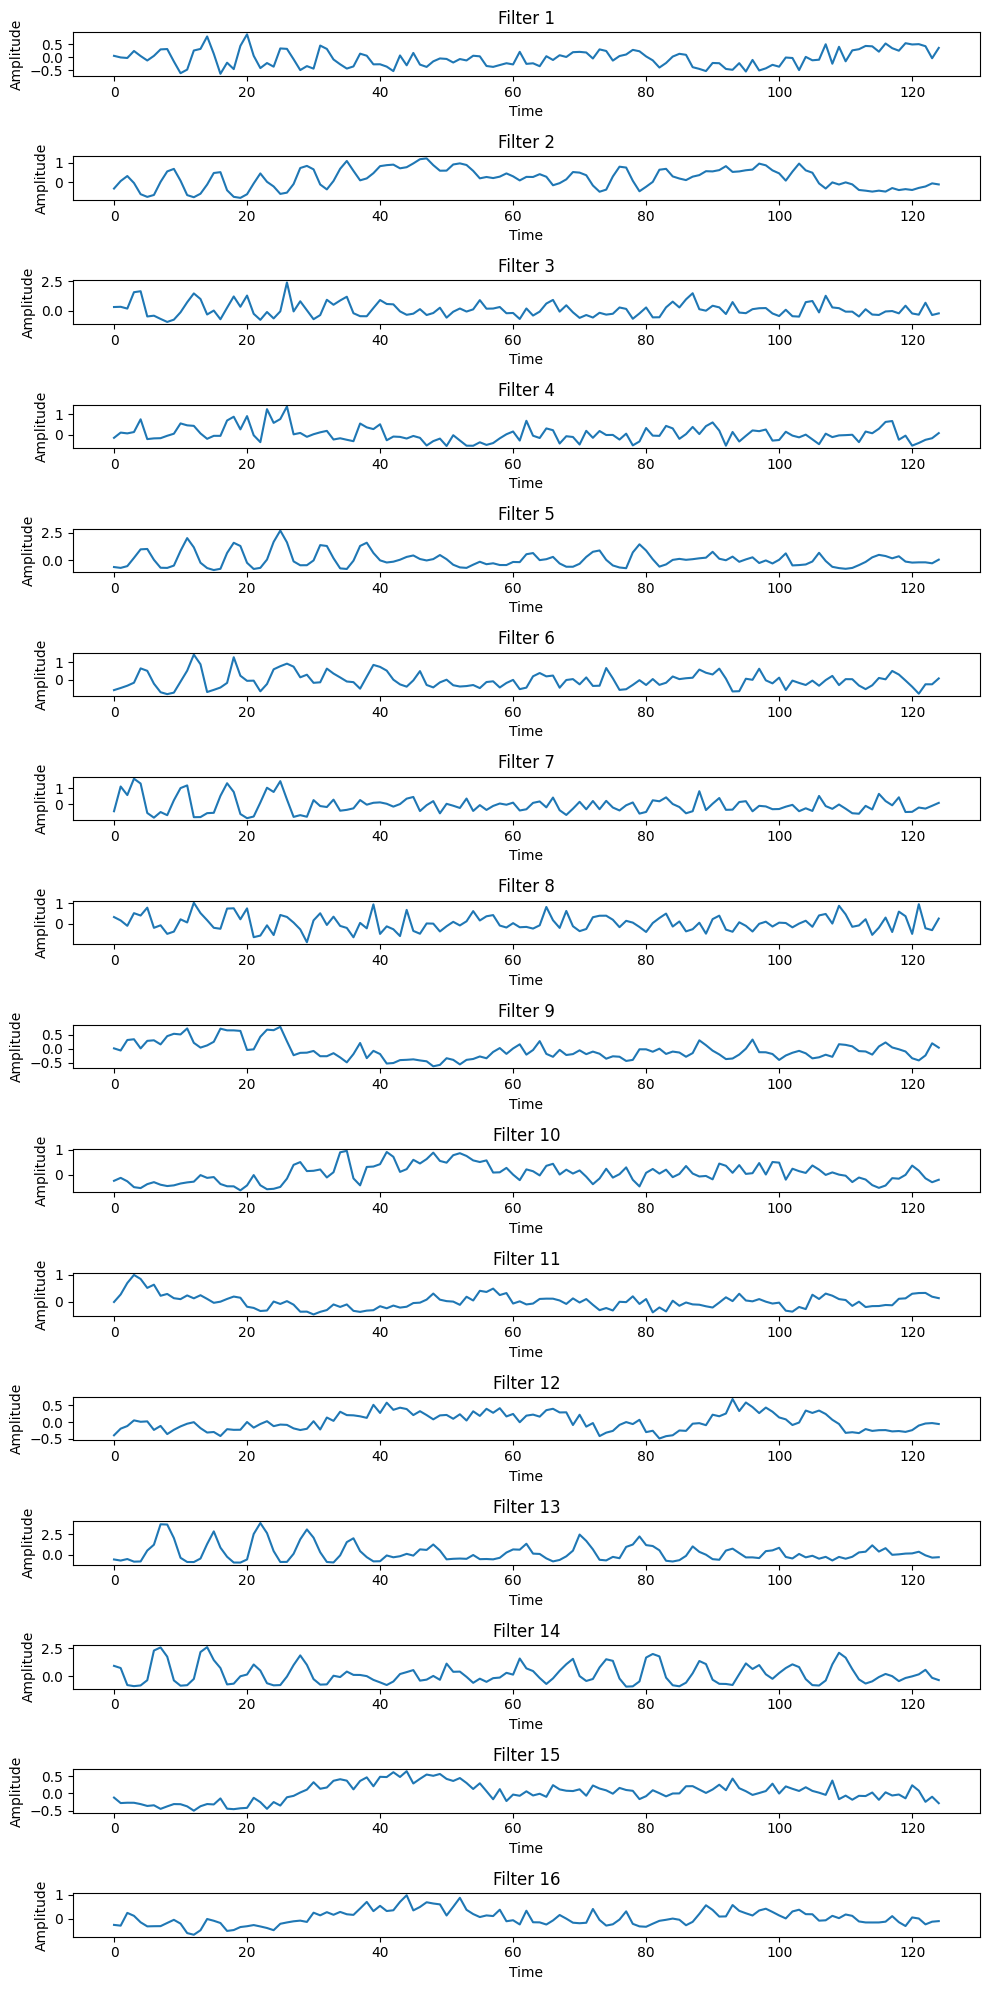

Layer Name : dropout
Feature Maps Shape : (1, 1, 125, 16)


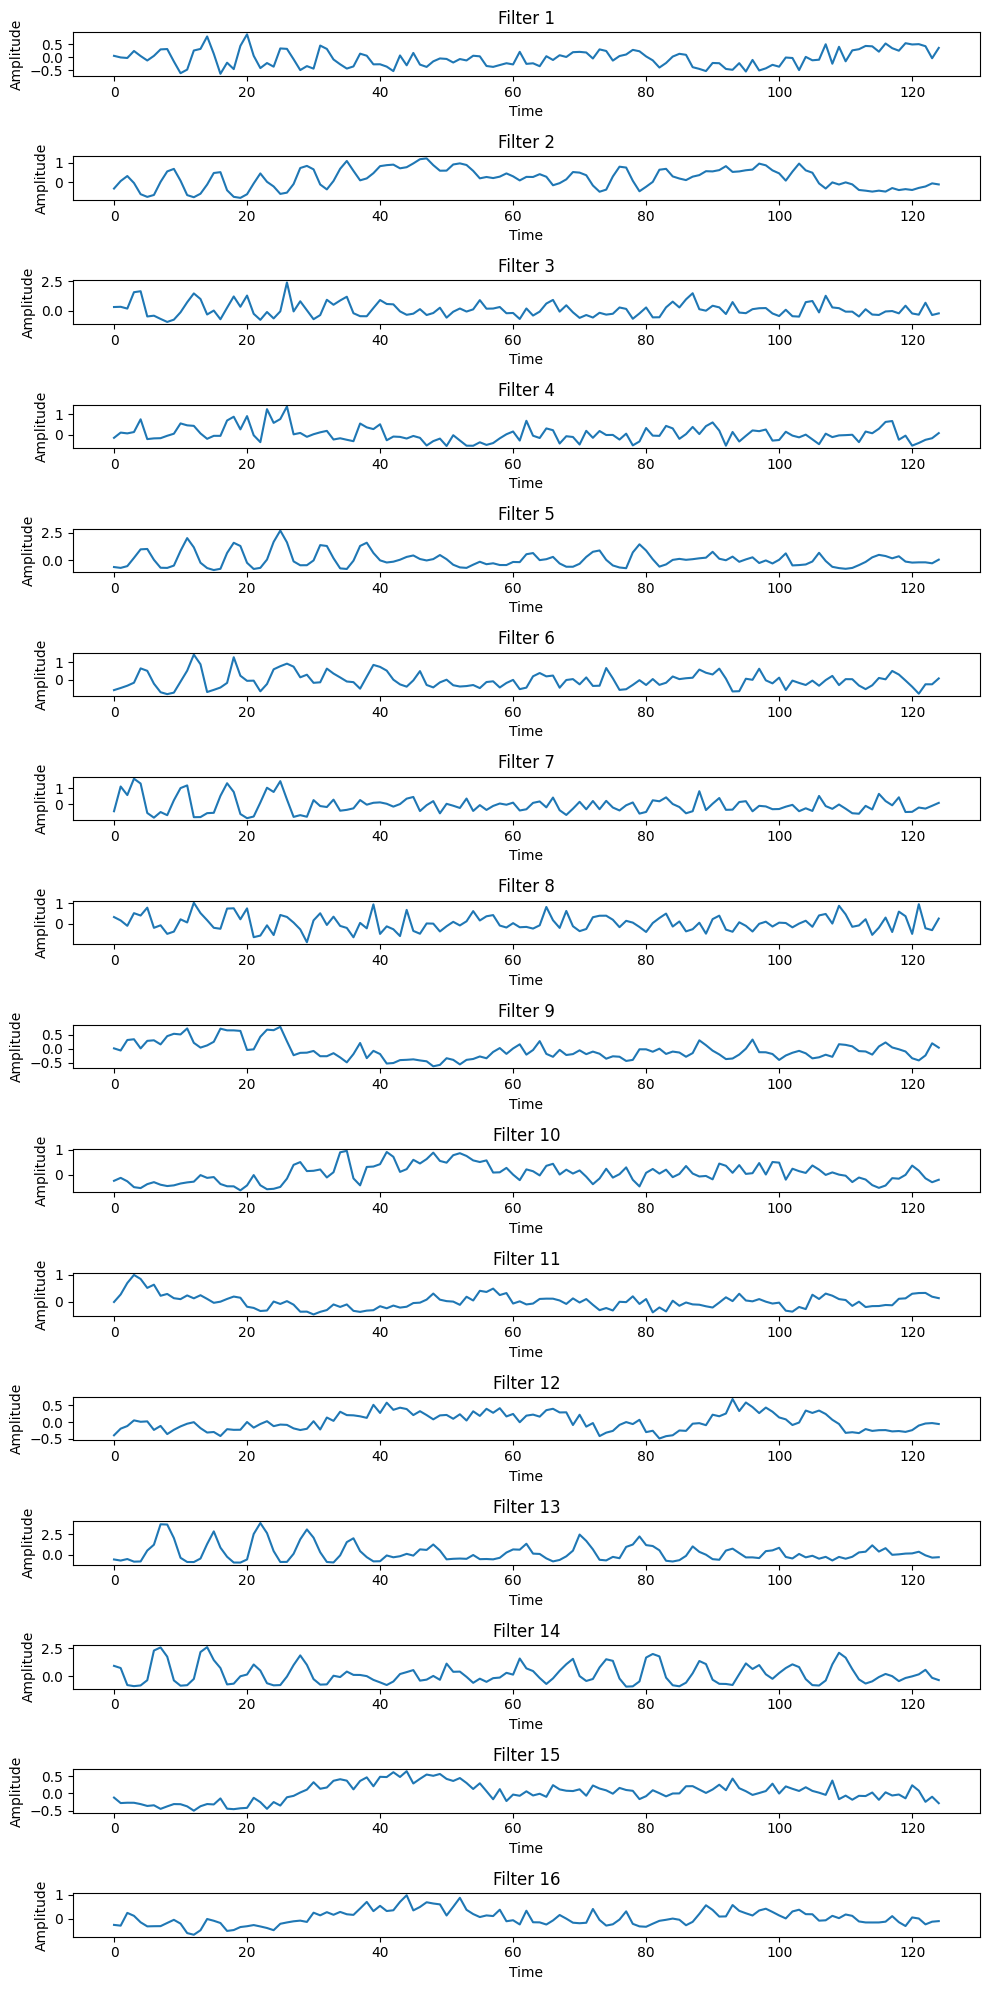

Layer Name : separable_conv2d
Feature Maps Shape : (1, 1, 125, 16)


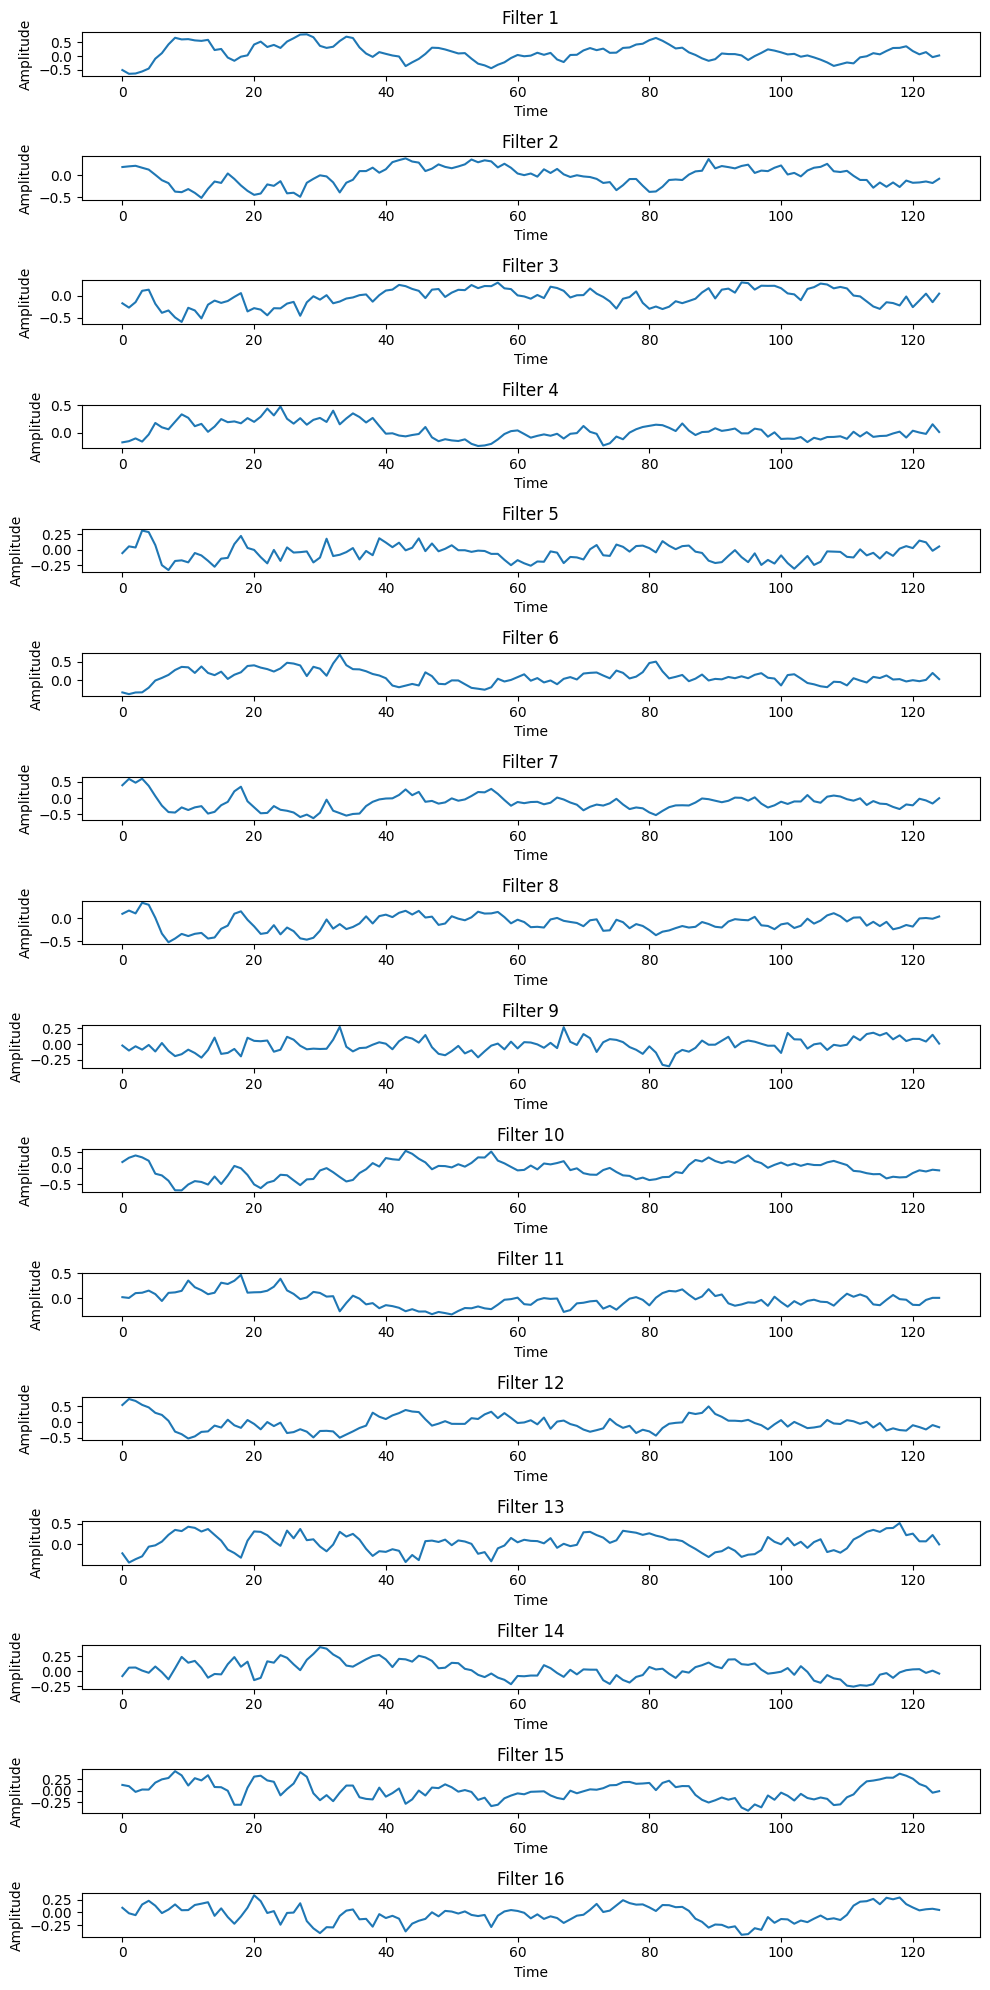

Layer Name : batch_normalization_2
Feature Maps Shape : (1, 1, 125, 16)


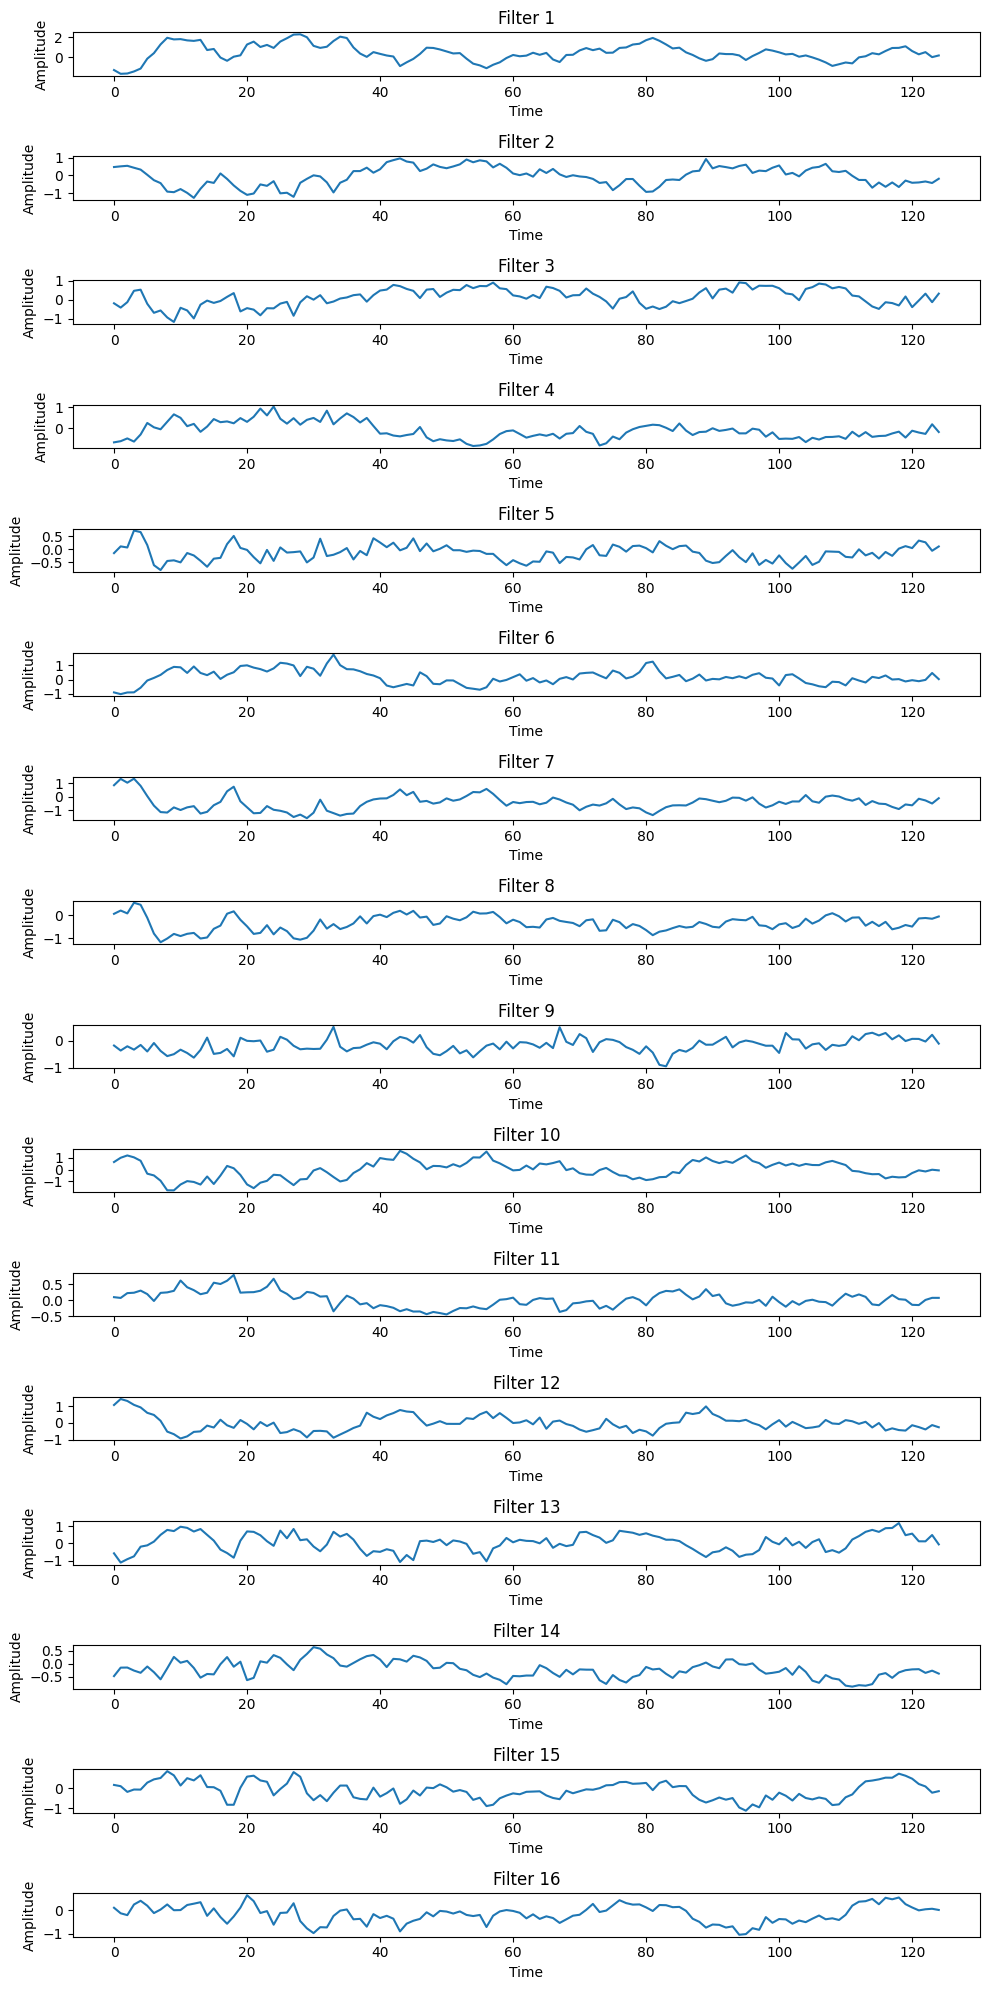

Layer Name : activation_1
Feature Maps Shape : (1, 1, 125, 16)


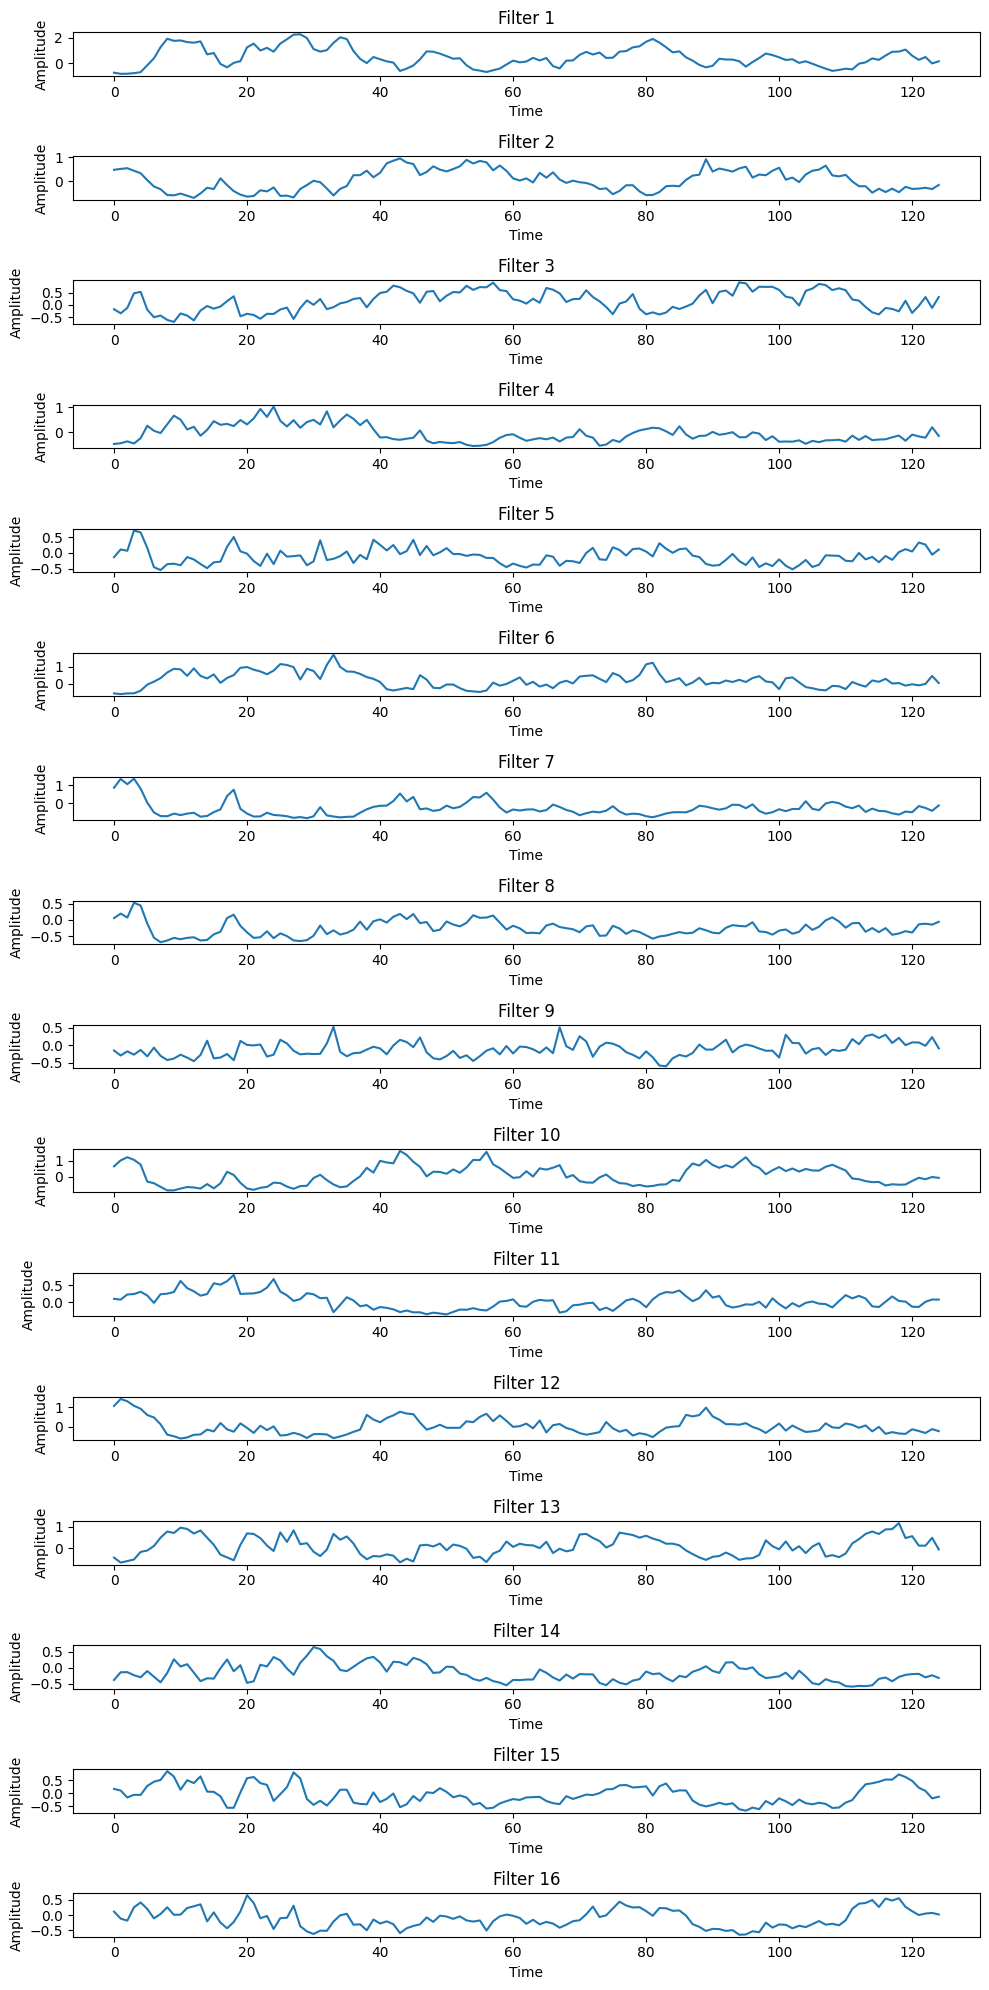

Layer Name : average_pooling2d_1
Feature Maps Shape : (1, 1, 15, 16)


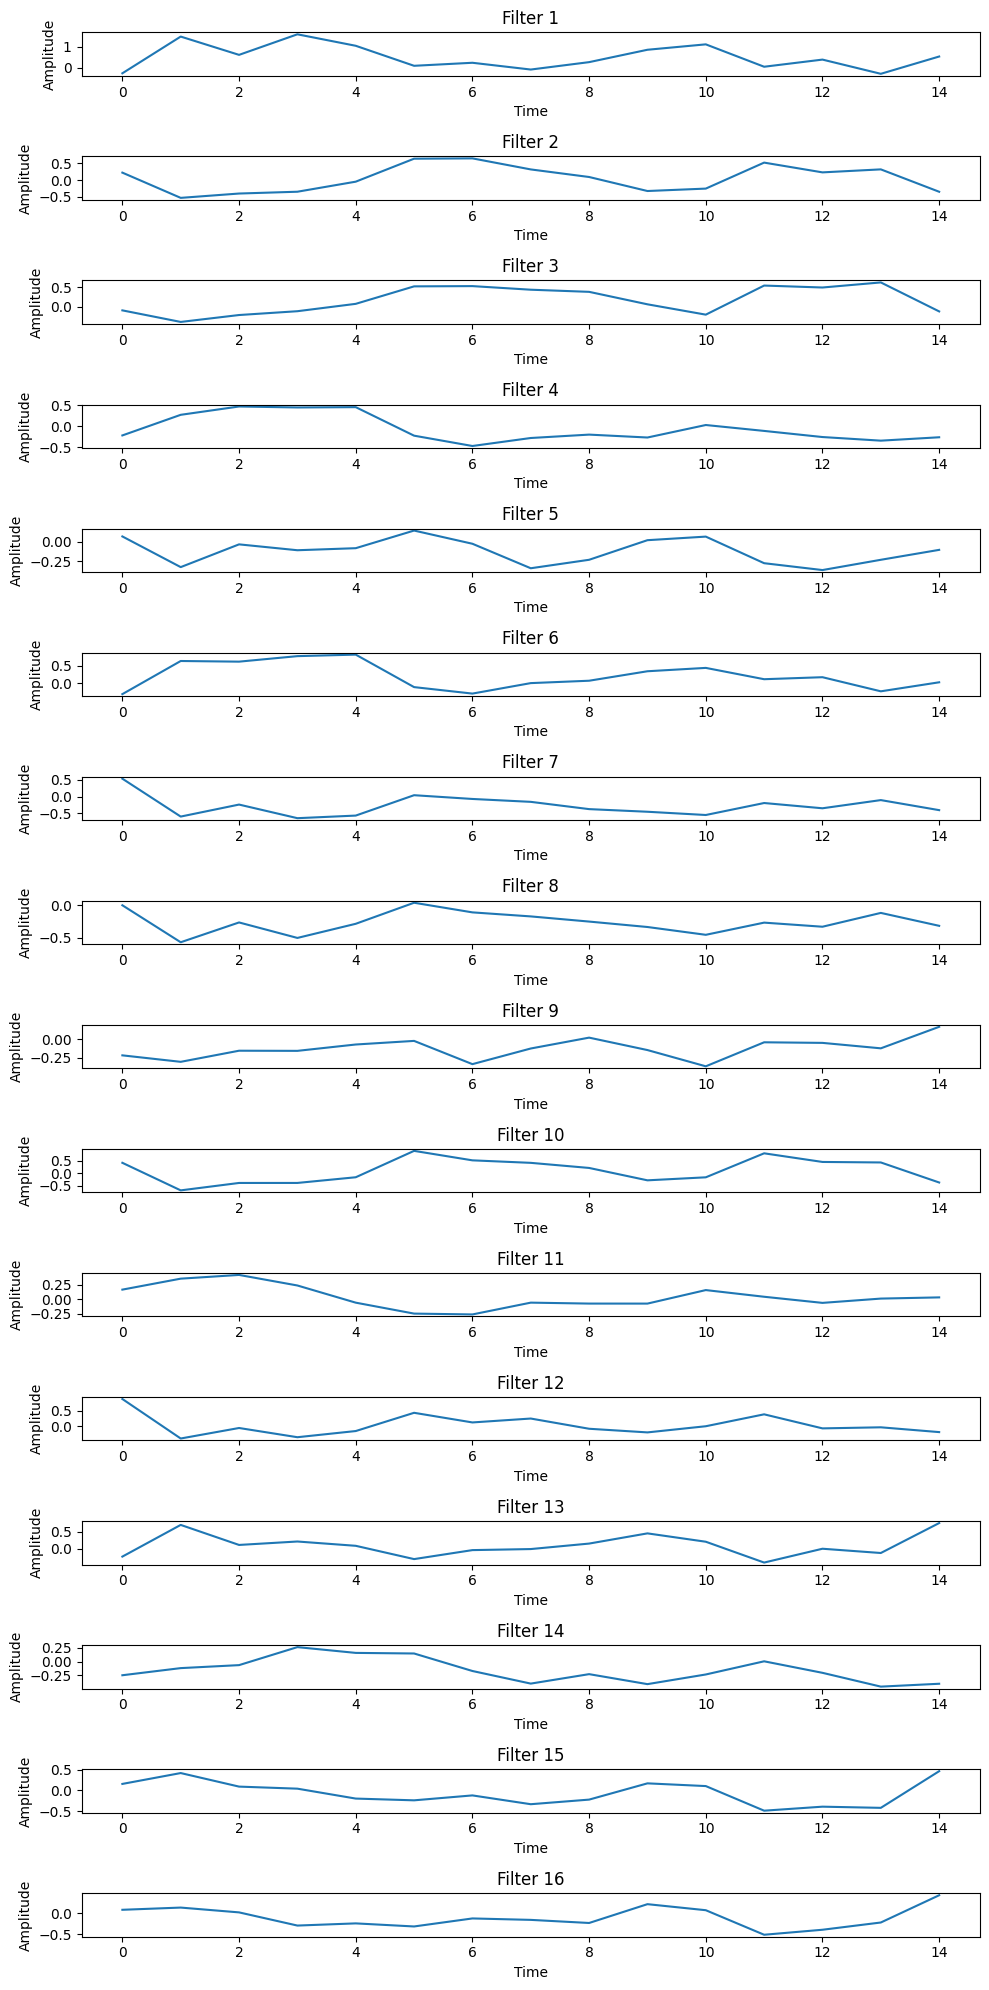

Layer Name : dropout_1
Feature Maps Shape : (1, 1, 15, 16)


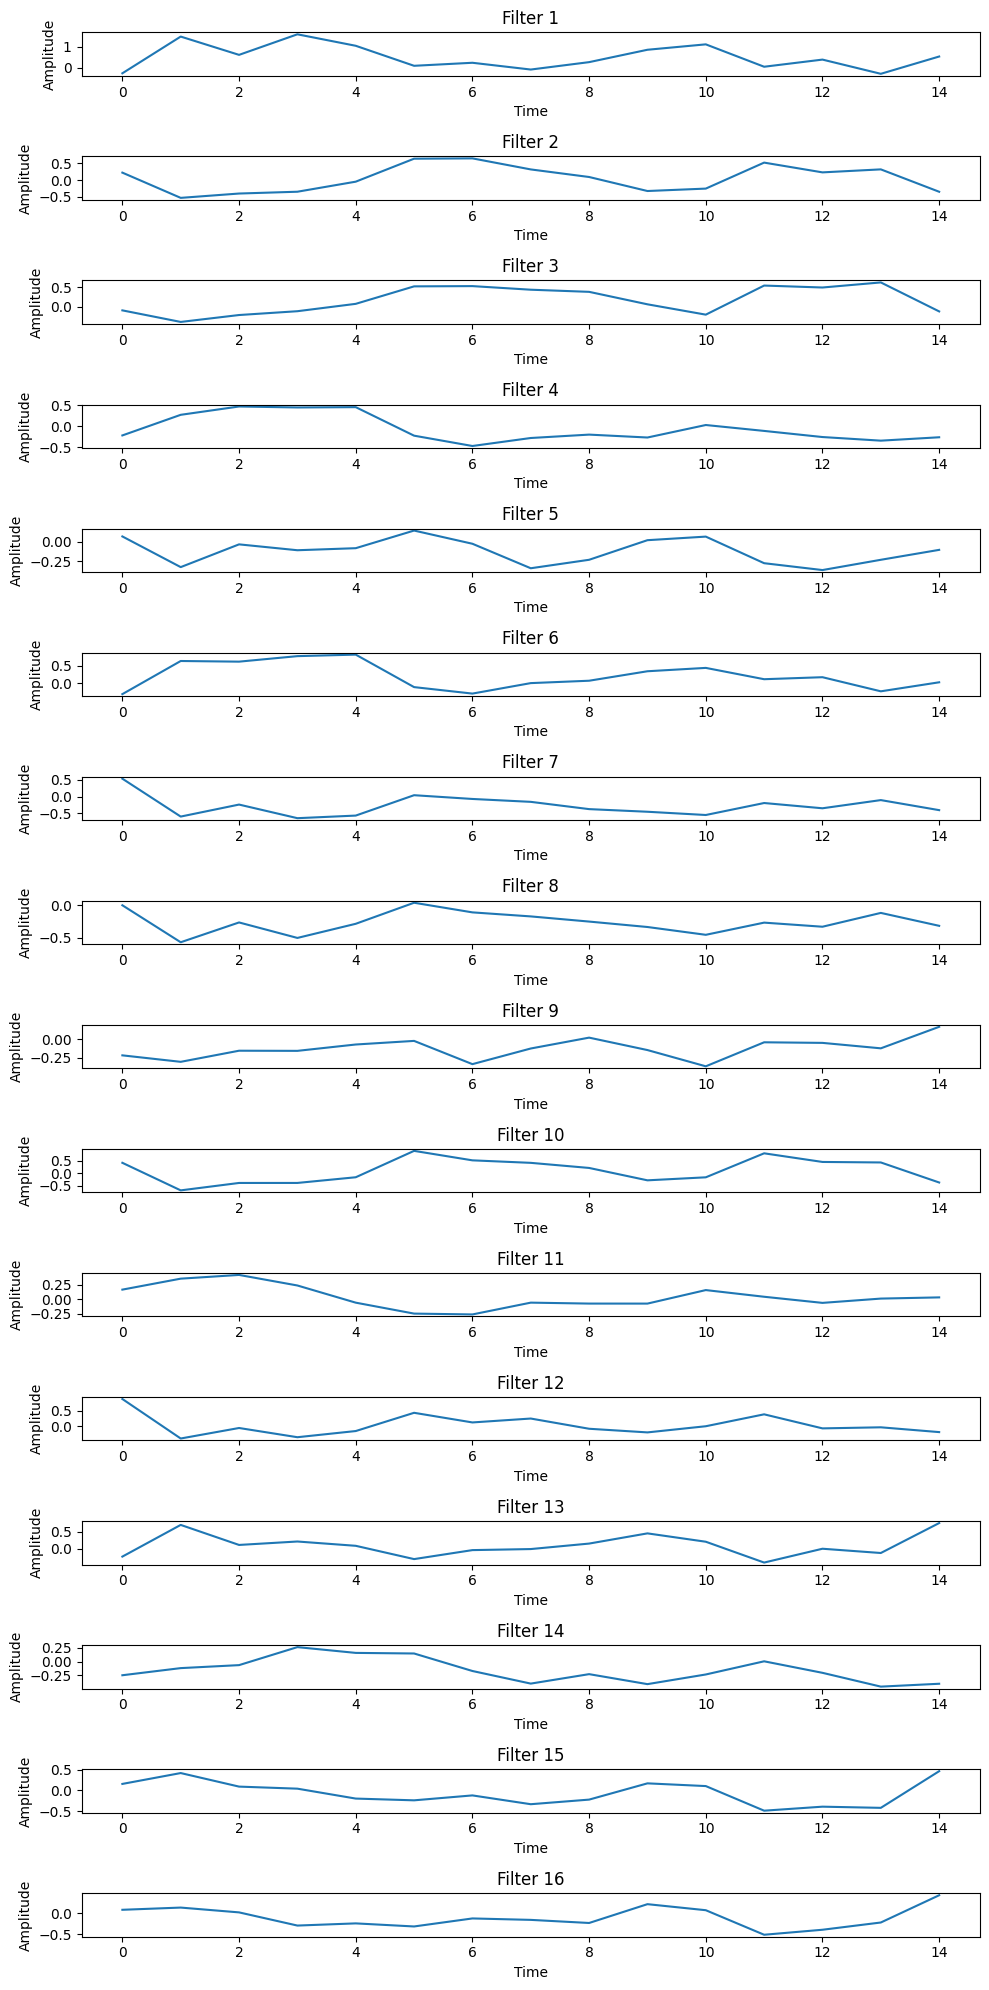

Layer Name : flatten
Feature Maps Shape : (1, 240)
Layer Name : dense
Feature Maps Shape : (1, 2)
Layer Name : softmax
Feature Maps Shape : (1, 2)


In [76]:
size_dict = {1: 7, 8: 20, 16: 20}

successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

eeg_sample = X_test[0]
eeg_sample = eeg_sample.reshape(1, chans, samples, kernels)

x = np.array(eeg_sample)

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print("Layer Name :", layer_name)
    print("Feature Maps Shape :", feature_map.shape)
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        # Plot n_features number of graphs in a row
        size = feature_map.shape[-1]
        fig, axes = plt.subplots(n_features, 1, figsize=(10, size_dict[size]))
        if n_features == 1:
            axes.plot(feature_map[0, :, :, 0].T)
            axes.set_title(f"Filter 1")
            axes.set_xlabel("Time")
            axes.set_ylabel("Amplitude")
        else:
            for i in range(n_features):
                axes[i].plot(feature_map[0, :, :, i].T)
                axes[i].set_title(f"Filter {i+1}")
                axes[i].set_xlabel("Time")
                axes[i].set_ylabel("Amplitude")

        plt.tight_layout()
        plt.show()

